In [1]:
from datetime import datetime
import time

import gdax
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
NUM_LEVELS = 256
SZ = int(1e5)
INITIAL_WAIT = 10
TIME_STEP = 0.5
C_CHECKPOINTS = 500

In [3]:
class OrderBookInmensus(gdax.OrderBook):
    def __init__(self, product_id='BTC-USD', log_to=None):
        super(OrderBookInmensus, self).__init__(product_id=product_id)
        
    def on_open(self):
        self._sequence = -1
        print("-- Subscribed to OrderBook(Inmensus)! --\n")
        
    def on_error(self, e, data=None):
        self.error = e
        self.stop = True
        print('Error: {} - data: {}'.format(e, data))
        

In [4]:
order_book = OrderBookInmensus(product_id='BTC-USD')

In [5]:
order_book.start()
time.sleep(INITIAL_WAIT)
order_book.close()

-- Subscribed to OrderBook(Inmensus)! --


-- OrderBook Socket Closed! --


In [6]:
order_book.get_current_book()['bids'][-1]

[Decimal('6117.80000000'),
 Decimal('0.02000000'),
 'b4c4bdf4-370b-4eaf-9311-ea53dcb2063f']

Wall time: 131 ms


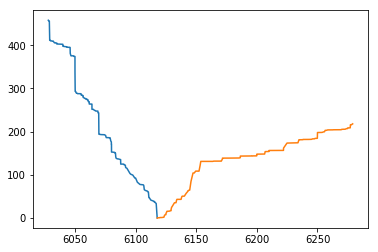

In [7]:
%%time
def aggregate(orders, is_bid):
    dfreq = {}
    for dp, dv, _ in orders:
        sp = str(dp)
        v = np.float(dv)
        if sp in dfreq:
            dfreq[sp] += v
        else:
            dfreq[sp] = v
    
    lfreq = list(dfreq.items())
    lfreq = [(np.float(p), v) for p, v in lfreq]
    lfreq.sort()
    
    if is_bid:
        return np.asarray(lfreq[-NUM_LEVELS:])
    else:
        return np.asarray(lfreq[:NUM_LEVELS])

def get_vols(order_book):
    cur_book = order_book.get_current_book()
    bid_vols = aggregate(cur_book['bids'], True)
    ask_vols = aggregate(cur_book['asks'], False)
    return bid_vols, ask_vols

bv, av = get_vols(order_book)
plt.plot(bv[:, 0], bv[:, 1].sum() - bv[:, 1].cumsum())
plt.plot(av[:, 0], av[:, 1].cumsum())

In [8]:
bid_record = np.zeros((SZ, NUM_LEVELS, 2))
ask_record = np.zeros((SZ, NUM_LEVELS, 2))
time_record = np.zeros(SZ)
print("Will last", SZ / 60.0 / 60, "hours")

Will last 27.77777777777778 hours


In [9]:
def record_order_book(idx, order_book, t):
    bv, av = get_vols(order_book)
    bid_record[idx] = bv
    ask_record[idx] = av
    time_record[idx] = t

In [10]:
%%time
record_order_book(0, order_book, time.time())

Wall time: 122 ms


In [ ]:
order_book.start()
print("Doing initial sleep...")
time.sleep(INITIAL_WAIT)
print("Collecting data...")

print("Recording order_book every {} seconds for {} seconds".format(TIME_STEP, SZ))
per_checkpoint = SZ // C_CHECKPOINTS
try:
    idx = 0
    for idx in range(SZ):
        beg_time = time.time()
        
        #in case of error, make sure the order_book is still open
        if order_book.stop:
            print("Orderbook is stopped, restarting...")
            order_book.start()
            print("Doing initial sleep...")
            time.sleep(INITIAL_WAIT)
            print("Collecting data...")
        
        record_order_book(idx, order_book, time.time())
        
        #logging
        print("\r", bid_record[idx,-5:,0], ask_record[idx,-5:,0], time.time() - beg_time, end="")
        if idx % per_checkpoint == 0:
            print()
        
        end_time = time.time()
        elapsed_time = end_time - beg_time
        time.sleep(max(TIME_STEP - elapsed_time, 0))
        
except KeyboardInterrupt as e:
    order_book.close()
    raise(e)

-- Subscribed to OrderBook(Inmensus)! --

Doing initial sleep...


In [ ]:
plt.plot(time_record)

In [ ]:
plt.plot(bid_record[:,:,1].sum(axis=1))
plt.plot(ask_record[:,:,1].sum(axis=1))

In [ ]:
np.save('data/bid-record.npy', bid_record)
np.save('data/ask-record.npy', ask_record)
np.save('data/time-record.npy', time_record)